## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 4.6 MB/s 
     |████████████████████████████████| 212 kB 19.9 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
#load the emotion dataset (quite similar to the way we do it in tfds.load_dataset(...))
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[2], labels[2]

('im grabbing a minute to post i feel greedy wrong', 'anger')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
#create a tokenizer which maps the 10000 most frequent words in the dataset to a number. Other words are marked as <UNK>
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

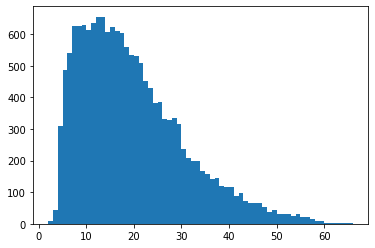

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
pad_sequences

<function keras.preprocessing.sequence.pad_sequences>

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen = maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq

array([[   2,  139,    3, ...,    0,    0,    0],
       [   2,   40,  101, ...,    0,    0,    0],
       [  17, 3060,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  327, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]], dtype=int32)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

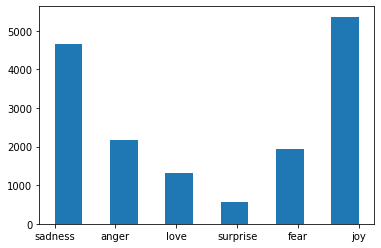

In [ ]:
plt.hist(labels, bins = 11)
plt.show()
#The dataset is an example of unbalanced classes since the distribution among different classes is not quite uniform

In [ ]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'anger': 3, 'fear': 2, 'joy': 1, 'love': 4, 'sadness': 5, 'surprise': 0}

In [ ]:
index_to_class

{0: 'surprise', 1: 'joy', 2: 'fear', 3: 'anger', 4: 'love', 5: 'sadness'}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

5


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
#Additional info : the output for the first embedding layer will be (50 x 16).
#We are using a bidirectional LSTM layer in order to preserve context in the tweets
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000, 16, input_length = 50),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [ ]:
h = model.fit(padded_train_seq, train_labels, validation_data = (val_seq, val_labels), epochs = 20, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/20
500/500 [==============================] - 40s 61ms/step - loss: 1.3549 - accuracy: 0.4773 - val_loss: 0.9600 - val_accuracy: 0.6680
Epoch 2/20
500/500 [==============================] - 29s 57ms/step - loss: 0.6734 - accuracy: 0.7526 - val_loss: 0.6738 - val_accuracy: 0.7555
Epoch 3/20
500/500 [==============================] - 29s 57ms/step - loss: 0.4128 - accuracy: 0.8587 - val_loss: 0.5258 - val_accuracy: 0.8255
Epoch 4/20
500/500 [==============================] - 28s 55ms/step - loss: 0.2420 - accuracy: 0.9243 - val_loss: 0.4723 - val_accuracy: 0.8485
Epoch 5/20
500/500 [==============================] - 27s 54ms/step - loss: 0.1653 - accuracy: 0.9484 - val_loss: 0.4286 - val_accuracy: 0.8655
Epoch 6/20
500/500 [==============================] - 27s 55ms/step - loss: 0.1129 - accuracy: 0.9645 - val_loss: 0.4436 - val_accuracy: 0.8740
Epoch 7/20
500/500 [==============================] - 28s 56ms/step - loss: 0.0983 - accuracy: 0.9697 - val_loss: 0.4564 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

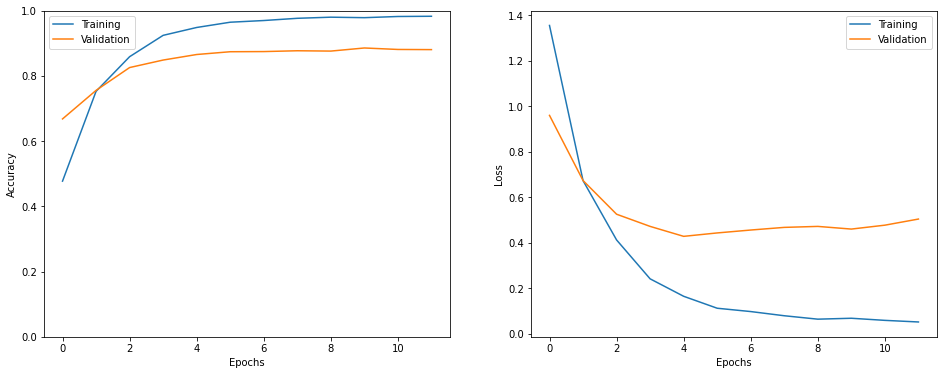

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
i = random.randint(0, len(test_labels)-1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted class:', pred_class)

Sentence: im feeling angry at someone i do something thoughtful for her and my feelings toward her soften
Emotion: anger
Predicted class: anger


In [ ]:
preds = model.predict(test_seq)
predictions = np.argmax(preds, axis = 1)

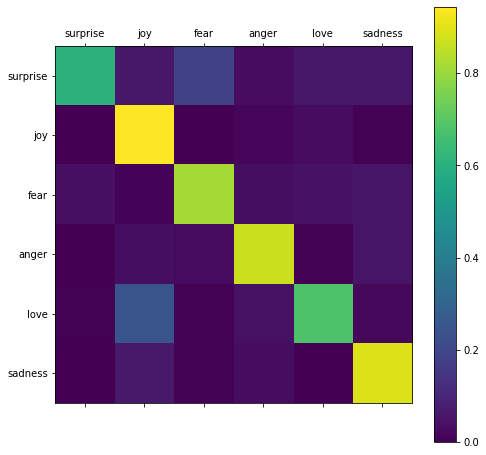

In [ ]:
#According to the confusion matrix, the pairs: (surprise, fear) and (love, joy) are quite problematic
show_confusion_matrix(test_labels, predictions, list(classes))